# Adding Foregrounds to the Simulated CMB
### Jeff McMahon and Renée Hložek 

The previous notebook simulated a purely CMB realisation of the sky. We now want to add in foregrounds to the CMB map. We will start by reading in the parameters we defined in the previous notebook.

## Code preliminaries
We use the following libraries in this code.  All are available through Anaconda.

In [1]:
import os
import sys
import numpy as np
import astropy.io.fits as fits

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import constants as cs
from cmb_modules import *

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width = cs.X_width
Y_width = cs.Y_width
pix_size = cs.pix_size

### Just some matplotlib and seaborn parameter tuning

In [2]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## Section 1.3: Point Source Map

Point sources in CMB maps arise from a number of astrophysical objects including Active Galactic Nuclei (AGN), Dust Star Forming Galaxies (DSFGs), and a bright tail of lensed DSFGs.  All of theses objects are interesting in their own right.  For the purposes of our mock skies we approximate these populations as a combination of a faint distribution of sources with a poisson distribution of brightness and small number of very bright sources with and exponentially falling source count.   This approximates the distribution of faint and bright sources seen in real CMB maps.   The source parameters were chosen by eye to look about the same as real maps at 150 GHz.   Detailed source counts have been published and can be consulted to add more reality into these simulations.  Publications also detail the frequency scalings of these sources.  In general DSFGs grow brighter at higher frequencies while AGNs have a spectrum that falls with increasing frequencies.  These behaviors must be included in multifrequency analyses and simulations.

In [3]:
# Paramaters to set up the Poisson point source distribution
number_of_sources  = 5000
amplitude_of_sources = 200
number_of_sources_EX = 50
amplitude_of_sources_EX = 1000

In [4]:
def poisson_source_component(N, pix_size, number_of_sources, amplitude_of_sources):
    """
    Makes a realization of a naive Poisson distributed point source map.
    
    Parameters:
    -----------
    N : int
        Number of pixels in the linear dimension.
    pix_size : float
        Size of a pixel in arcminutes.
    number_of_sources : int
        Number of Poisson distributed point sources on the source map.
    amplitude_of_sources : float
        Amplitude of point sources, which serves as the `lambda` parameter
        for the Poisson-distribution used to choose random points from.

    Returns:
    --------
    PSMap : array of shape (N, N)
        The Poisson distributed point sources marked on the map in the form of a 2D matrix.
    """
    PSMap = np.zeros([int(N),int(N)])
    # We throw random numbers repeatedly with amplitudes given by a Poisson distribution around the mean amplitude
    for i in range(number_of_sources):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand()) 
        PSMap[pix_x, pix_y] += np.random.poisson(lam=amplitude_of_sources)

    return(PSMap)

In [5]:
def exponential_source_component(N, pix_size, number_of_sources_EX, amplitude_of_sources_EX):
    """
    Makes a realization of a naive exponentially-distributed point source map
    
    Parameters:
    -----------
    N : int
        Number of pixels in the linear dimension.
    pix_size : float
        Size of a pixel in arcminutes.
    number_of_sources_EX : int
        Number of exponentially distributed point sources on the source map.
    amplitude_of_sources_EX : float
        Amplitude of point sources, which serves as the scale parameter
        for the exponential distribution

    Returns:
    --------
    PSMap : array of shape (N, N)
        The exponentially distributed point sources marked on the map in the form of a 2D matrix.
    """
    PSMap = np.zeros([int(N), int(N)])
    # We throw random numbers repeatedly with amplitudes given by an exponential distribution around the mean amplitude
    for i in range(number_of_sources_EX):
        pix_x = int(N*np.random.rand()) 
        pix_y = int(N*np.random.rand()) 
        PSMap[pix_x,pix_y] += np.random.exponential(scale=amplitude_of_sources_EX)

    return(PSMap) 

In [20]:
# Make a point source map by generating Poisson distributed background and
# adding the exponentially distributed sources over that
PSMap = poisson_source_component(N, pix_size, number_of_sources, amplitude_of_sources)
PSMap += exponential_source_component(N, pix_size, number_of_sources_EX, amplitude_of_sources_EX)

hist, bins = np.histogram(PSMap, bins=50, range=[0.001, PSMap.max()])
width = 1.0 * np.diff(bins).min()
centers = (bins[1:] + bins[:-1]) / 2

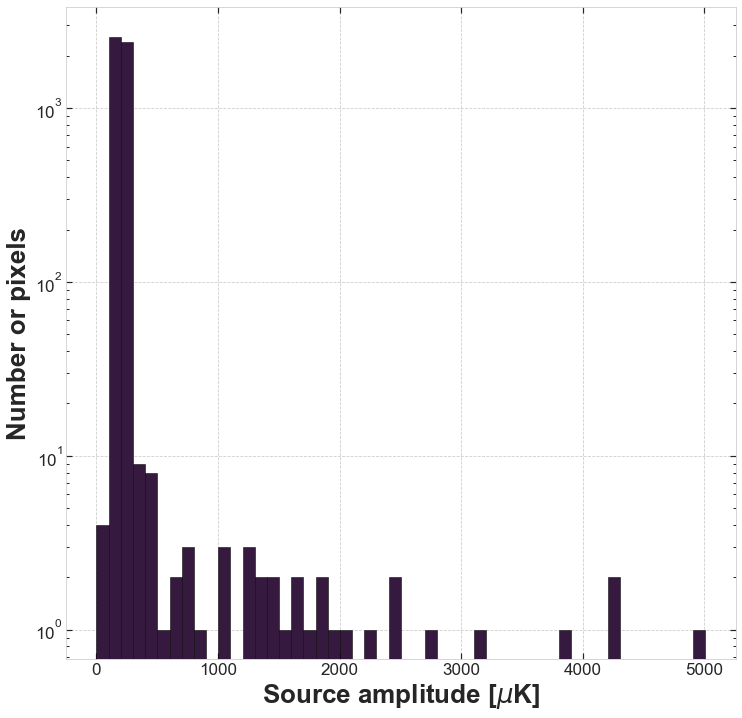

In [21]:
fig, axes = plt.subplots(figsize=(12, 12))

axes.set_yscale('log')
axes.bar(centers, hist, width=width,
         ec='black', lw=0.5)

axes.set_xlabel('Source amplitude [$\mu$K]', fontsize=axislabelsize, fontweight='bold')
axes.set_ylabel('Number or pixels', fontsize=axislabelsize, fontweight='bold')
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

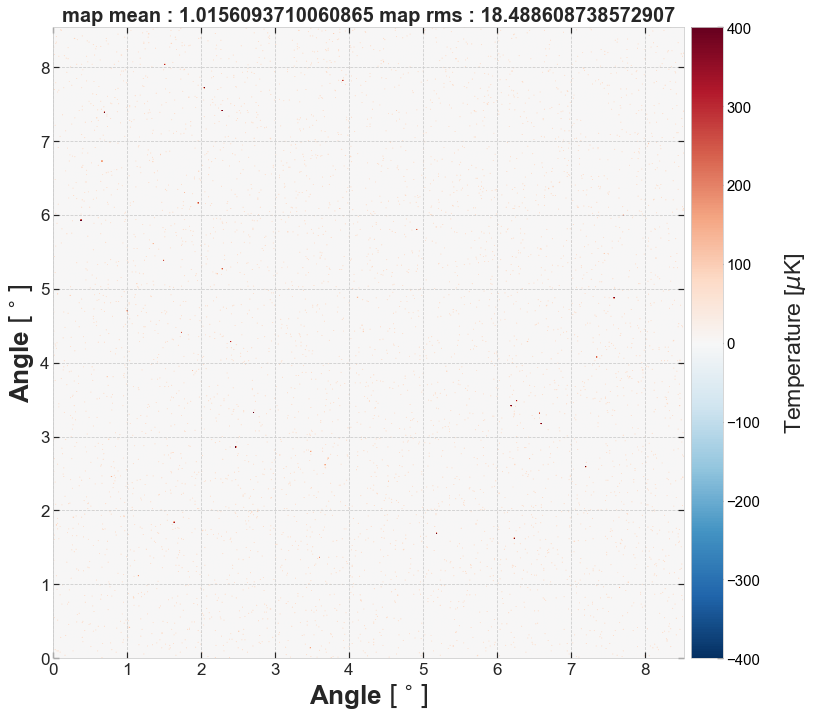

In [23]:
plot_CMB_map(PSMap, X_width, Y_width, c_min, c_max)

The top plot shows a histogram of brightness of the pixels in our source map.   The lower plot shows a map of the point source map we have simulated.

<font color='red'>EXCERCISE: </font> Plot a histogram of the Poisson sources and a histogram of the exponetial sources.   How do these two distributions differ?

In [24]:
# Poisson
hist_p, bins_p = np.histogram(poisson_source_component(N, pix_size, number_of_sources, amplitude_of_sources), bins=50, range=[0.001, PSMap.max()])
width_p = 1.0 * np.diff(bins_p).min()
centers_p = (bins_p[1:] + bins_p[:-1]) / 2
# Exponential
hist_e, bins_e = np.histogram(exponential_source_component(N, pix_size, number_of_sources_EX, amplitude_of_sources_EX), bins=50, range=[0.001, PSMap.max()])
width_e = 1.0 * np.diff(bins_e).min()
centers_e = (bins_e[1:] + bins_e[:-1]) / 2

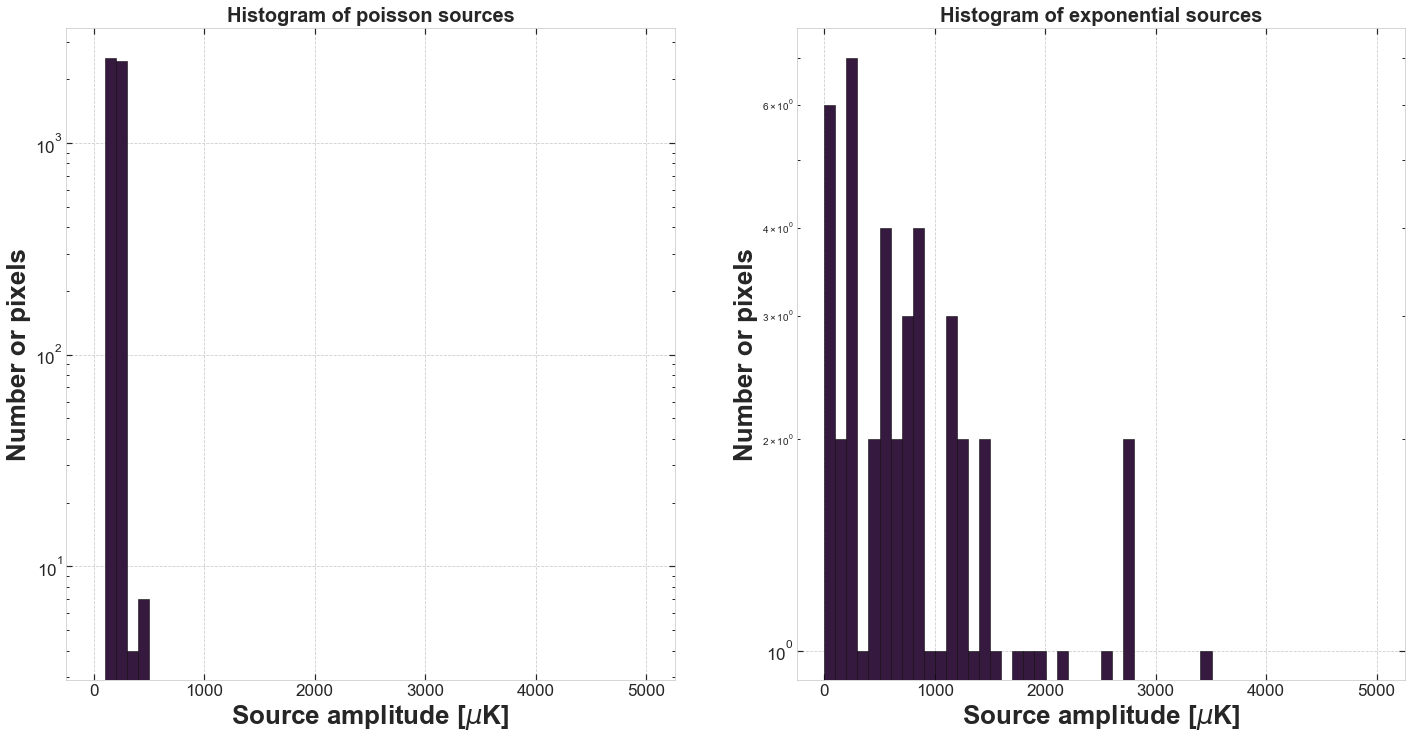

In [25]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*12))

axes[0].bar(centers_p, hist_p, width=width_p,
            ec='black', lw=0.5)
axes[1].bar(centers_e, hist_e, width=width_e,
            ec='black', lw=0.5)

titles = ['poisson', 'exponential']
for i in range(ncols):
    axes[i].set_yscale('log')
    axes[i].set_title('Histogram of {0} sources'.format(titles[i]), fontsize=axistitlesize, fontweight='bold')
    axes[i].set_xlabel('Source amplitude [$\mu$K]', fontsize=axislabelsize, fontweight='bold')
    axes[i].set_ylabel('Number or pixels', fontsize=axislabelsize, fontweight='bold')
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

We can clearly see, that however Possion sources are more abundant, they only contribute to a very narrow slice of source amplitudes in the inverval $\left[ 0, 500 \right]$. In contrast the exponential sources cover a much wider range in the amplitude domain.

## Section 1.4: SZ Map

Clusters of galaxies imprint a subtle distortion into CMB maps that is most apparent on arcminute scales.    While clusters of galaxies are named after the galaxies bound within them, the galaxies represent only a small fraction of the matter contained within a cluster.   Roughly 80% of the baryons are not contained within galaxies, but rather exist as a cloud of gas bound within the gravitational potential well created by a dark matter halo that caries the vast majority of the mass of the cluster.  Within this well, the dilute gas becomes ionized and heated to temperatures of millions of Kelvin.  Occasionally a CMB photon interacts with one of the hot electrons in this ionized gas.  This interaction (inverse Compton scattering) gives the CMB photon a boost in energy.  Detailed calculations show that this effect (the Sunyev-Zeldovich or SZ effect) leads to decrement of power at frequencies below the 'null' at 220 GHz and extra power at higher frequencies.  This result is redshift independent.  Thus the SZ effect provides a clean way to detect clusters of galaxies and the signal which traces the electron density within the cluster.  The SZ signal is a reasonably good tracer of cluster mass.

For these simulations we treat each cluster as having a brightness "beta profile", and fix each cluster to have an identical angular size.  We draw the distribution of central temperatures from the exponential distribution to simplify the code and reduce the dependance on external libraries.  For more accurate simulations, a range of clusters sizes should be used, a distribution of cluster shapes (with more accurate profiles) should be considered, and the number of clusters as a function of mass and redshift should be chosen to match measurements of the cluster mass function.

In [44]:
# Paramaters to set up the SZ point sources
number_of_SZ_clusters = 500
mean_amplitude_of_SZ_clusters = 50
SZ_beta = 0.86
SZ_theta_core = 1.0

In [45]:
def SZ_source_component(N, pix_size, number_of_SZ_clusters, mean_amplitude_of_SZ_clusters, SZ_beta, SZ_theta_core, do_plots):
    """
    Makes a realization of a naive SZ effect map.

    Parameters:
    -----------
    N : int
        Number of pixels in the linear dimension.
    pix_size : float
        Size of a pixel in arcminutes.
    number_of_SZ_clusters : int
        desc
    mean_amplitude_of_SZ_clusters : float
        desc
    SZ_beta : float
        desc
    SZ_Theta_core : float
        desc
    do_plots : bool
        desc

    Returns:
    --------
    SZMap : 
        desc
    SZcat : 
        desc
    """

    # Placeholder for the SZ map
    SZmap = np.zeros([N,N])
    # Catalogue of SZ sources, X, Y, amplitude
    SZcat = np.zeros([3, number_of_SZ_clusters])
    # make a distribution of point sources with varying amplitude
    for i in range(number_of_SZ_clusters):
        pix_x = int(N*np.random.rand())
        pix_y = int(N*np.random.rand())
        pix_amplitude = np.random.exponential(mean_amplitude_of_SZ_clusters)*(-1)
        SZcat[0,i] = pix_x
        SZcat[1,i] = pix_y
        SZcat[2,i] = pix_amplitude
        SZmap[pix_x,pix_y] += pix_amplitude

    if do_plots:
        hist, bins = np.histogram(SZMap,bins = 50,range=[SZmap.min(),-10])
        width = 1.0 * np.diff(bins).min()
        centers = (bins[1:] + bins[:-1]) / 2
        fig, axes = plt.subplots(figsize=(12,12))
        axes.set_yscale('log')
        axes.bar(centers, hist, width=width,
                 ec='black', lw=0.5)
        axes.set_xlabel('Source amplitude [$\mu$K]', fontsize=axislabelsize, fontweight='bold')
        axes.set_ylabel('Number of pixels', fontsize=axislabelsize, fontweight='bold')
        axes.tick_params(axis='both', which='major', labelsize=axisticksize)
        plt.show()

    # make a beta function
    beta = beta_function(N, pix_size, SZ_beta, SZ_theta_core)

    # convolve the beta function with the point source amplitude to get the SZ map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SZmap = np.fft.fft2(np.fft.fftshift(SZmap))
    SZmap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SZmap)))

    # return the SZ map
    return(SZmap, SZcat)

In [46]:
def beta_function(N, pix_size, SZ_beta, SZ_theta_core):
    """
    Makes a beta function.
    
    Parameters:
    -----------
    N : int
        Number of pixels in the linear dimension.
    pix_size : float
        Size of a pixel in arcminutes.
    SZ_beta : float
        desc
    SZ_theta_core : float
        desc

    Returns:
    --------
    beta : array of shape (N, N)
    """
    ones = np.ones(N)
    inds  = (np.arange(N) + 0.5 - N/2) * pix_size
    X = np.outer(ones, inds)
    Y = np.transpose(X)
    # Compute the same real-space R function as before for the PS
    R = np.sqrt(X**2 + Y**2)
    
    beta = (1 + (R/SZ_theta_core)**2)**((1-3*SZ_beta)/2)

    # return the beta function map
    return(beta)

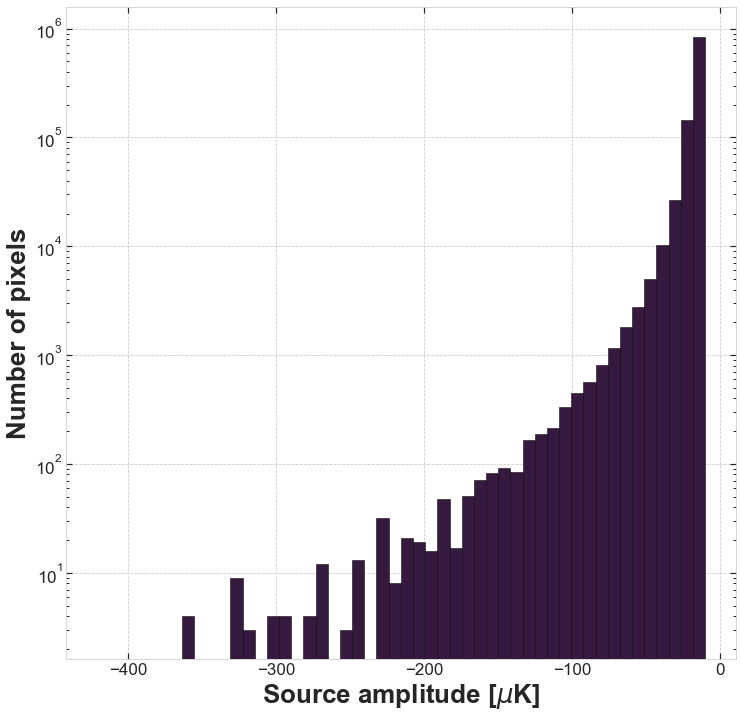

In [47]:
SZmap, SZcat = SZ_source_component(N, pix_size, number_of_SZ_clusters, mean_amplitude_of_SZ_clusters, SZ_beta, SZ_theta_core,
                                   do_plots=True)

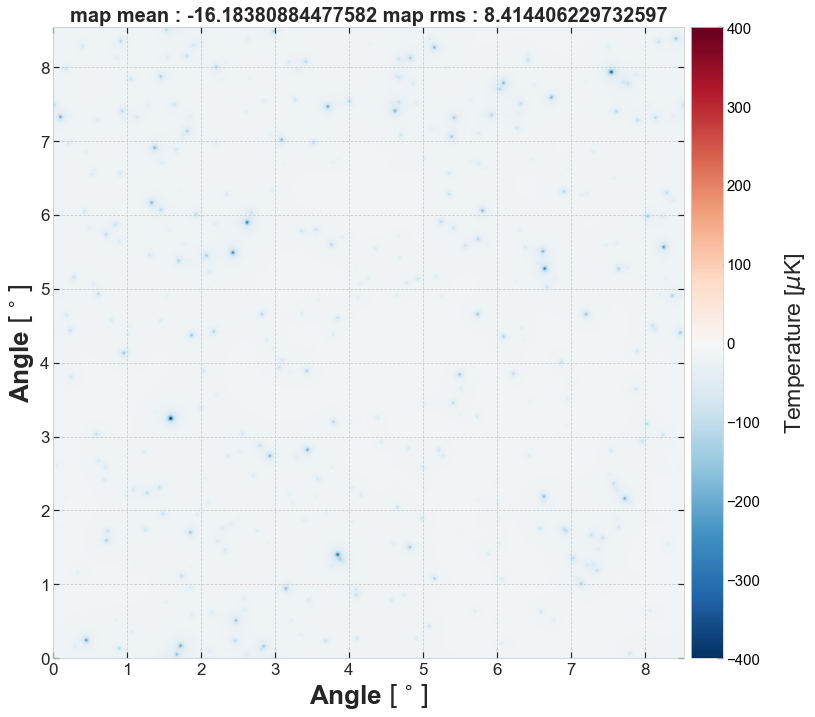

In [48]:
plot_CMB_map(SZMap, X_width, Y_width, c_min, c_max)

The top plot shows the a histogram of the SZ-decrements from our simulated SZ cluster map.  The bottom plot shows our simulated SZ map. This map is at 150 GHz. How could you tell just from looking at the code above?

<font color='red'>EXCERCISE: </font>  In reality the cluster radii vary from cluster to cluster.  For reference the radius depends on redshift and mass.  The number of clusters as a function of mass and redshift is called the cluster 'mass function' which is a sensitive cosmological proble.  

To enhance the realism of our sims, divide the simulated cluster sample into an extremely large radius sample (1 cluster with a 30 arcminute radius, comparable to the Comma cluster; the largest cluster on the sky), a large radius bin (10%) clusters with 5 arcminute radius), a medium bin (30%) with 2 arcminute radius, and a small bin (60% with 0.5 arcminute radius).  

In [31]:
# your code goes here

Comment on whether or not your map looks reaosnable.   Also explain why (given the algorithm we are using) we didn't draw the cluster radius from a continuous distribution.

## 1.5 Full Sky Map

The sky map is a combination of the CMB anisotropy, a point source map, and an SZ map.  In an appendix we add the impact of CMB lensing.

In [32]:
# Read in the input CMB spectra
data = np.genfromtxt('CAMB_fiducial_cosmo_scalCls.dat')
ell = data[:,0]
DlTT = data[:,1]

In [35]:
## remake the CMB map from the pervious excercise
CMB_T, ClTT2d, FT_2d, ell2d = make_CMB_T_map(ell, DlTT, N, pix_size)
## add all the componets together
total_map = CMB_T + PSMap + SZMap

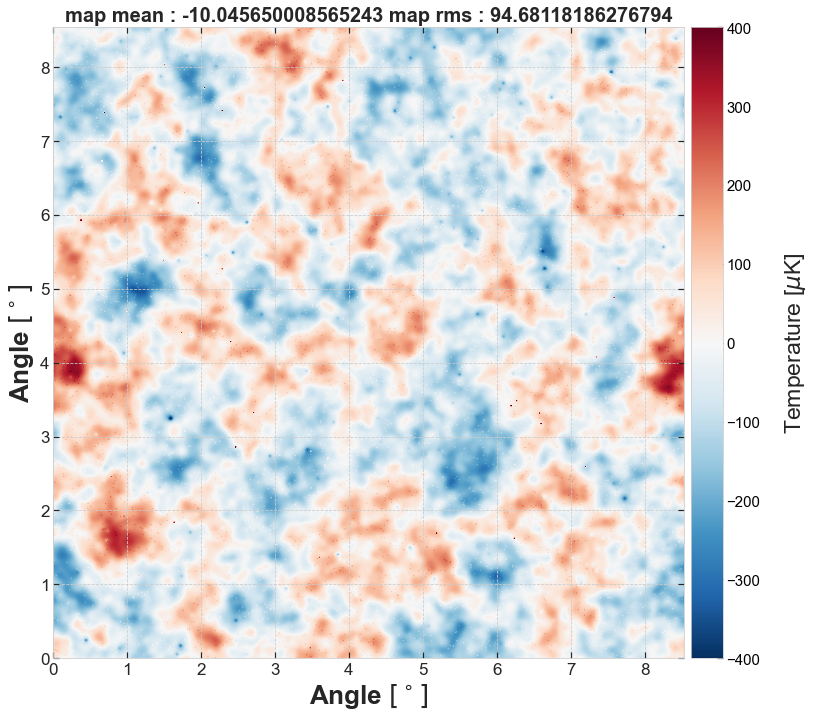

In [36]:
plot_CMB_map(total_map, X_width, Y_width, c_min, c_max)

This plot shows our simulated map that includes CMB, point source, and SZ cluster signals.  Note that the sources seem brighter than what we saw in the real observed maps.   This is not a mistake, as will be seen after we fold in the beam (point spread function) of the instrument.